# Spatial averaging/ Coarse graining

Here we do a coarse graining on the time averaged fields. 

In [1]:
# load modules
import xarray as xr
import numpy  as np
from xgcm import Grid
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Load time averages 
Model_Tav = xr.open_dataset('./outputs_ncfiles/Model_Tav.nc')
Trac_Tav  = xr.open_dataset('./outputs_ncfiles/Trac_Tav.nc')

In [3]:
grid = Grid(Model_Tav, periodic='X')

In [4]:
list_tracers = ['TRAC01', 'TRAC02','TRAC03','TRAC04','TRAC05',
                'TRAC06','TRAC07','TRAC08','TRAC09','TRAC10',
                'TRAC11', 'TRAC12','TRAC13','TRAC14','TRAC15',
                'TRAC16','TRAC17','TRAC18','TRAC19','TRAC20']

list_tracers2 = ['Tr01', 'Tr02','Tr03','Tr04','Tr05',
                'Tr06','Tr07','Tr08','Tr09','Tr10',
                'Tr11', 'Tr12','Tr13','Tr14','Tr15',
                'Tr16','Tr17','Tr18','Tr19','Tr20']

vels = {'uVeltave':'U', 'vVeltave':'V', 'wVeltave':'W'}
vels_zonal = {'vVeltave':'V', 'wVeltave':'W'}

In [5]:
Lcoarse = 50e3 # needs to be a multiple of the domain size.
idmax   = int( (Model_Tav.dyC[0,0].values * len(Model_Tav.YC))/Lcoarse) # numper of grid points to average over
nreps   = int( len(Model_Tav.YC)/idmax )

In [6]:
# Coarse grain velocities 

YCicoarse = np.repeat(range(idmax),nreps)
#XCicoarse = np.repeat(range(idmax),nreps)

# Interpolate mean velocities to all be on same point.# Interp 
Model_Tav['WmeanC'] = grid.interp(Model_Tav.wVeltave, 'Z', boundary='extend')
Model_Tav['VmeanC'] = grid.interp(Model_Tav.vVeltave, 'Y', boundary='extend')
#Model_Tav['UmeanC'] = grid.interp(Model_Tav.uVeltave, 'X')

#Model_Tav.coords['XCicoarse'] = ('XC', XCicoarse)
Model_Tav.coords['YCicoarse'] = ('YC', YCicoarse)


YCcoarse = ('YCicoarse', Model_Tav.YC.groupby('YCicoarse').mean('YC'))
#XCcoarse = ('XCicoarse', Model_Tav.XC.groupby('XCicoarse').mean('XC'))

# coarse grain mean velocities

Vels_coarse = xr.Dataset()


for i in vels_zonal:
    temp = (Model_Tav[vels[i]+'meanC'].groupby('YCicoarse').mean('YC')).mean('XC')
    
    temp_array = xr.DataArray(temp.data, coords = [temp.Z, YCcoarse], 
                             dims = ['Z', 'YCcoarse'])
    
    Vels_coarse[vels[i]] = temp_array
    
hFacCcoarse = ((Model_Tav.hFacC.groupby('YCicoarse').mean('YC')).mean('XC'))

Vels_coarse.coords['hFacCcoarse'] = (['Z', 'YCcoarse'], hFacCcoarse)

In [7]:
# Move eddy fluxes to center point
# for the time average
for key in list_tracers2: 
    Trac_Tav['DFrI'+key] = grid.interp(Trac_Tav['DFrI'+key],'Z', boundary='extend')
    
for key in list_tracers: 
        Trac_Tav['V'+key] = grid.interp(Trac_Tav['V'+key], 'Y', boundary='extend')
        Trac_Tav['U'+key] = grid.interp(Trac_Tav['U'+key], 'X')
        
# create coarse grained version of fluxes and mean tracers# create 

Trac_Tav.coords['YCicoarse'] = ('YC', YCicoarse)
#Trac_Tav.coords['XCicoarse'] = ('XC', XCicoarse)

YCcoarse = ('YCicoarse', Trac_Tav.YC.groupby('YCicoarse').mean('YC'))
#XCcoarse = ('XCicoarse', Trac_Tav.XC.groupby('XCicoarse').mean('XC'))

In [12]:
# flux datasets 
# stationary fluxes

Vzon = Model_Tav['VmeanC'].mean('XC')
Wzon = Model_Tav['WmeanC'].mean('XC')
Vs = Model_Tav['VmeanC'] - Vzon
Ws = Model_Tav['WmeanC'] - Wzon

for i in list_tracers:
    Czon = Trac_Tav[i].mean('XC')
    Cs = Trac_Tav[i]  - Czon
    
    # stationary flux
    Trac_Tav['Vs'+i+'s'] = (Vs*Cs).mean('XC')
    Trac_Tav['Ws'+i+'s'] = (Ws*Cs).mean('XC')
    
    # transient flux
    Trac_Tav['Vt'+i+'t'] = Trac_Tav['V'+i].mean('XC') - Trac_Tav['Vs'+i+'s'] - Vzon*Czon
    Trac_Tav['Wt'+i+'t'] = Trac_Tav['W'+i].mean('XC') - Trac_Tav['Ws'+i+'s'] - Wzon*Czon
    
    # mean flux 
    Trac_Tav['Vm'+i+'m'] = Vzon*Czon
    Trac_Tav['Wm'+i+'m'] = Wzon*Czon

In [8]:
Trac_coarse = xr.Dataset()

for i in Trac_Tav.data_vars:
    temp_var = (Trac_Tav[i].groupby('YCicoarse').mean('YC')).mean('XC')
    temp = xr.DataArray(temp_var.data, coords = [temp_var.Z, YCcoarse], 
                             dims = ['Z', 'YCcoarse'] )
    Trac_coarse[i] = temp

In [11]:
# flux datasets 
# trasient fluxes

# stationary plus transient flux together
for i in list_tracers: 
    #Trac_coarse['Up'+i+'p'] = Trac_coarse['U'+i] - Vels_coarse['U'] * Trac_coarse[i]    
    Trac_coarse['Vp'+i+'p'] = Trac_coarse['V'+i] - Vels_coarse['V'] * Trac_coarse[i]
    Trac_coarse['Wp'+i+'p'] = Trac_coarse['W'+i] - Vels_coarse['W'] * Trac_coarse[i]

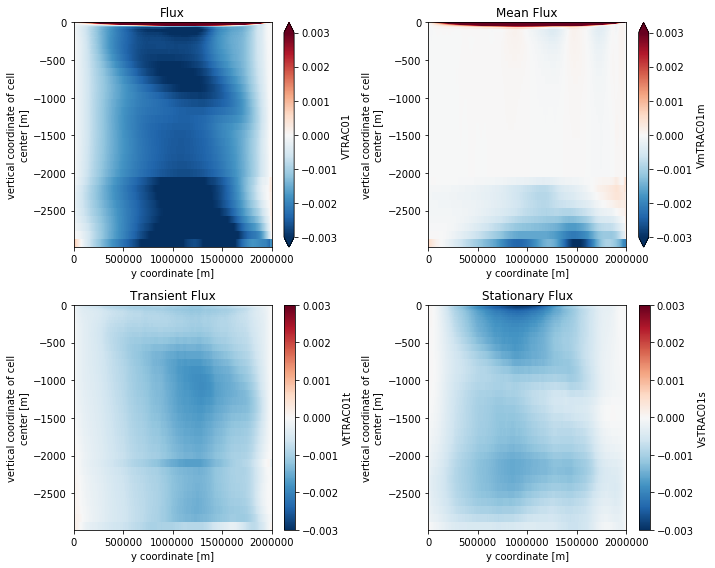

In [15]:
plt.figure(figsize=(10,8))

plt.subplot(221)
Trac_Tav['VTRAC01'].mean('XC').plot(vmin=-3e-3)
plt.title('Flux')

plt.subplot(222)
Trac_Tav['VmTRAC01m'].plot(vmin=-3e-3)
plt.title('Mean Flux')

#(Trac_Tav['VtTRAC01t']+Trac_Tav['VsTRAC01s']+Trac_Tav['VmTRAC01m']).plot(vmin=-3e-3)

plt.subplot(223)
Trac_Tav['VtTRAC01t'].plot(vmin=-3e-3)
plt.title('Transient Flux')


plt.subplot(224)
Trac_Tav['VsTRAC01s'].plot(vmin=-3e-3)
plt.title('Stationary Flux')

plt.tight_layout()

In [16]:
for i in list_tracers:
    temp_var = (Trac_Tav['Vs'+i+'s'].groupby('YCicoarse').mean('YC'))
    temp = xr.DataArray(temp_var.data, coords = [temp_var.Z, YCcoarse], 
                             dims = ['Z', 'YCcoarse'] )
    Trac_coarse['Vs'+i+'s'] = temp
    
    temp_var = (Trac_Tav['Ws'+i+'s'].groupby('YCicoarse').mean('YC'))
    temp = xr.DataArray(temp_var.data, coords = [temp_var.Z, YCcoarse], 
                             dims = ['Z', 'YCcoarse'] )
    Trac_coarse['Ws'+i+'s'] = temp
    
    temp_var = (Trac_Tav['Vt'+i+'t'].groupby('YCicoarse').mean('YC'))
    temp = xr.DataArray(temp_var.data, coords = [temp_var.Z, YCcoarse], 
                             dims = ['Z', 'YCcoarse'] )
    Trac_coarse['Vt'+i+'t'] = temp
    
    temp_var = (Trac_Tav['Wt'+i+'t'].groupby('YCicoarse').mean('YC'))
    temp = xr.DataArray(temp_var.data, coords = [temp_var.Z, YCcoarse], 
                             dims = ['Z', 'YCcoarse'] )
    Trac_coarse['Wt'+i+'t'] = temp

In [18]:
Trac_coarse.coords['drF'] = Trac_Tav.drF
#Trac_coarse.coords['hFacCcoarse'] = (['Z', 'YCcoarse', 'XCcoarse'], hFacCcoarse)

In [19]:
# Calculate gradients 

# Z grads (don't need staggered grid)
for i in list_tracers:
    Trac_coarse[i+'_Z'] = -grid.diff(grid.interp(Trac_coarse[i], 'Z', boundary='extend'),
                                    'Z', boundary='extend')/Trac_coarse.drF

In [20]:
# To calculate the tracer gradients we need a staggered coordinate

# make staggered coordinates
temp = np.repeat(idmax, nreps/2)
#temp2 = np.repeat(idmax-1, nreps/2)
YSicoarse = np.concatenate([YCicoarse[int(nreps/2):], temp])
#XSicoarse = np.concatenate([temp2, XCicoarse[:-int(nreps/2)]])

trac_stag = xr.Dataset()

for i in list_tracers: 
    trac_stag[i] = Trac_Tav[i]
    
#trac_stag.coords['XSicoarse'] = ('XC', XSicoarse)
trac_stag.coords['YSicoarse'] = ('YC', YSicoarse)

In [22]:
# Y gradient
# only average in Y direction on staggered points to take Y average. 
# average in X direction is on center points
tracsav_stag = xr.Dataset()
for i in list_tracers:
    tracsav_stag[i] = (trac_stag[i].groupby('YSicoarse').mean('YC')).mean('XC')
    
for i in list_tracers:
    temp = tracsav_stag[i].diff('YSicoarse')/Lcoarse
    # dy on the end points in Y direction are not full size
    temp[:,0] = temp[:,0] * 4/3
    temp[:,-1] = temp[:,-1] * 4/3 
    
    temp = xr.DataArray(temp.data, coords=[Trac_coarse.Z, Trac_coarse.YCcoarse], 
                       dims=['Z', 'YCcoarse'])
    Trac_coarse[i+'_Y'] = temp
    

In [24]:
Trac_coarse.to_netcdf('outputs_ncfiles/Trac_coarse_zonal_'+str(int(Lcoarse//1e3))+'km')
Vels_coarse.to_netcdf('outputs_ncfiles/Vels_coarse_zonal_'+str(int(Lcoarse//1e3))+'km')

In [25]:
# Temperature fields

Tmean = Model_Tav.Ttave
Tmean.coords['YCicoarse'] = ('YC', YCicoarse)
#Tmean.coords['XCicoarse'] = ('XC', XCicoarse)

T_coarse = xr.Dataset()

YCcoarse = ('YCicoarse', Tmean.YC.groupby('YCicoarse').mean('YC'))
#XCcoarse = ('XCicoarse', Tmean.XC.groupby('XCicoarse').mean('XC'))
# coarse grain mean velocities


temp = (Tmean.groupby('YCicoarse').mean('YC')).mean('XC')
    
temp_array = xr.DataArray(temp.data, coords = [temp.Z, YCcoarse], 
                            dims = ['Z', 'YCcoarse'])
    
T_coarse['T'] = temp_array

In [26]:
# Z grads
T_coarse['T_Z'] = -grid.diff(grid.interp(T_coarse['T'], 'Z', boundary='extend'),
                                    'Z', boundary='extend')/Tmean.drF

In [27]:
Tstag = Tmean
Tstag.coords['YSicoarse'] = ('YC', YSicoarse)
#Tstag.coords['XSicoarse'] = ('XC', XSicoarse)

# Y grads 
Tstag_sav = (Tstag.groupby('YSicoarse').mean('YC')).mean('XC')

temp = Tstag_sav.diff('YSicoarse')/Lcoarse
temp[:,0] = temp[:,0] * 4/3
temp[:,-1] = temp[:,-1] * 4/3   
    
temp = xr.DataArray(temp.data, dims=['Z', 'YCcoarse'],
                    coords=[ T_coarse.Z, T_coarse.YCcoarse])
    
T_coarse['T_Y'] = temp

In [28]:
#Model_Tav['UTtave'] = grid.interp(Model_Tav.UTtave, 'X')
Model_Tav['VTtave'] = grid.interp(Model_Tav.VTtave, 'Y', boundary='extend')
Model_Tav['WTtave'] = grid.interp(Model_Tav.WTtave, 'Z', boundary='extend')

In [31]:
# flux datasets 
# stationary fluxes

Vzon = Model_Tav['VmeanC'].mean('XC')
Wzon = Model_Tav['WmeanC'].mean('XC')
Vs = Model_Tav['VmeanC'] - Vzon
Ws = Model_Tav['WmeanC'] - Wzon

Tzon = Model_Tav.Ttave.mean('XC')
Ts = Model_Tav.Ttave - Tzon

# stationary flux
Model_Tav['VsTs'] = (Vs*Ts).mean('XC')
Model_Tav['WsTs'] = (Ws*Ts).mean('XC')

# transient flux
Model_Tav['VtTt'] = Model_Tav['VTtave'].mean('XC') - Model_Tav['VsTs'] - Vzon*Tzon
Model_Tav['WtTt'] = Model_Tav['WTtave'].mean('XC') - Model_Tav['WsTs'] - Wzon*Tzon

# mean flux 
Model_Tav['VmTm'] = Vzon*Tzon
Model_Tav['WmTm'] = Wzon*Tzon

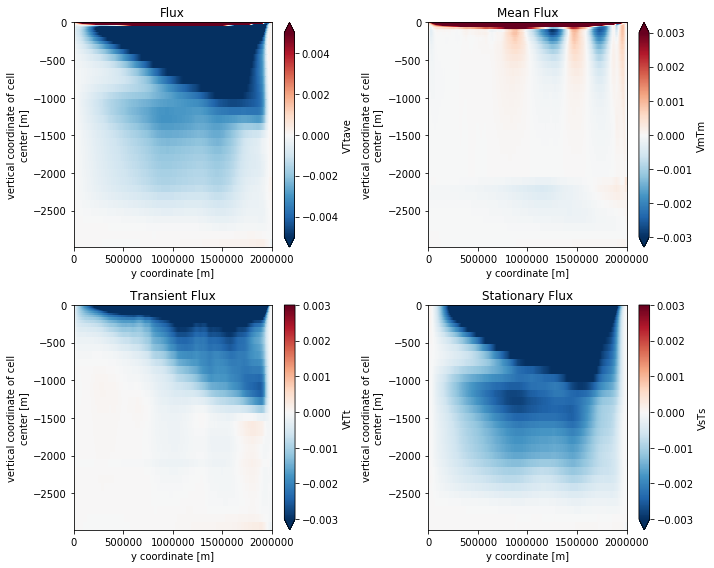

In [37]:
plt.figure(figsize=(10,8))

plt.subplot(221)
Model_Tav['VTtave'].mean('XC').plot(vmin=-5e-3)
plt.title('Flux')

plt.subplot(222)
Model_Tav['VmTm'].plot(vmin=-3e-3)
plt.title('Mean Flux')

#(Trac_Tav['VtTRAC01t']+Trac_Tav['VsTRAC01s']+Trac_Tav['VmTRAC01m']).plot(vmin=-3e-3)

plt.subplot(223)
Model_Tav['VtTt'].plot(vmin=-3e-3)
plt.title('Transient Flux')


plt.subplot(224)
Model_Tav['VsTs'].plot(vmin=-3e-3)
plt.title('Stationary Flux')

plt.tight_layout()

In [33]:
Model_Tav.coords['YCicoarse'] = ('YC', YCicoarse)
#Model_Tav.coords['XCicoarse'] = ('XC', XCicoarse)

for i in ['VT','WT']: 
    temp = (Model_Tav[i+'tave'].groupby('YCicoarse').mean('YC')).mean('XC') 
    temp = xr.DataArray(temp.data, dims=['Z', 'YCcoarse'],
                    coords=[T_coarse.Z ,T_coarse.YCcoarse])
    T_coarse[i] = temp
    
#T_coarse['UpTp'] = T_coarse['UT'] - Vels_coarse['U'] *T_coarse['T']
T_coarse['VpTp'] = T_coarse['VT'] - Vels_coarse['V'] *T_coarse['T']
T_coarse['WpTp'] = T_coarse['WT'] - Vels_coarse['W'] *T_coarse['T']

In [35]:
for i in ['VtTt','WtTt','VsTs','WsTs',]: 
    
    temp = (Model_Tav[i].groupby('YCicoarse').mean('YC')) 
    temp = xr.DataArray(temp.data, dims=['Z', 'YCcoarse'],
                    coords=[T_coarse.Z ,T_coarse.YCcoarse])
    T_coarse[i] = temp

In [36]:
T_coarse.to_netcdf('outputs_ncfiles/T_coarse_zonal_'+str(int(Lcoarse//1e3))+'km')